In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("OneDrive/Belgeler/data.csv", sep = ';' ,header = 'infer')

In [3]:
df = pd.DataFrame(df)

In [4]:
df.head(10)

,Ürün Adı,Satıcı,Bölge,Satış Adedi,Tutar
0,Telefon,Elif,Marmara,1.0,2400
1,Televizyon,Ahmet,Marmara,2.0,4800
2,Tablet,Alper,Ege,1.0,3800
3,Telefon,Ahmet,Marmara,1.0,1900
4,Fare,Elif,Marmara,1.0,300
5,Klavye,Alper,Ege,2.0,400
6,Televizyon,Mehmet,Doğu Anadolu,1.0,3600
7,Telefon,Kaan,İç Anadolu,NaN,3600
8,Telefon,Selin,Akdeniz,2.0,4200
9,Televizyon,Alper,Ege,NaN,9600


In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [7]:
import numpy as np
import math

In [8]:
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [9]:
df.isnull()

,Ürün Adı,Satıcı,Bölge,Satış Adedi,Tutar
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
95,False,False,False,False,False
96,False,False,True,False,False
97,False,False,False,False,False
98,False,False,False,False,False


In [10]:
df.isnull().sum()

Ürün Adı        0
Satıcı          0
Bölge          10
Satış Adedi     6
Tutar           0
dtype: int64

In [11]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()

In [12]:
def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category":
            df[n] = pd.Categorical(c, categories = train[n].cat.categories, ordered = True)

In [13]:
train_cats(df)

In [14]:
type(df["Ürün Adı"][1])

str

In [15]:
df["Ürün Adı"].cat.categories

Index(['Akıllı Saat', 'Fare', 'Klavye', 'Monitör', 'Tablet', 'Telefon',
       'Televizyon'],
      dtype='object')

In [16]:
df["Satıcı"].cat.categories

Index(['Ahmet', 'Alper', 'Elif', 'Kaan', 'Mehmet', 'Recep', 'Selin'], dtype='object')

In [17]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum:
            df[name+"_na"] = pd.isnull(col)
        df[name] = col.fillna(col.median())

In [18]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1

In [19]:
def proc_df(df, y_fld):
    
    y = df[y_fld].values
    df.drop([y_fld], axis = 1, inplace = True)
    
    for n, c in df.items():
        fix_missing(df, c, n)
        
    for n, c in df.items():
        numericalize(df, c, n)
    
    res = [df, y]
    

    
    return res

In [20]:
df_compare = df.copy()

In [21]:
df, y = proc_df(df, "Tutar")

In [22]:
df_compare, y_compare = proc_df(df_compare, "Tutar")

In [23]:
df.head(10)

,Ürün Adı,Satıcı,Bölge,Satış Adedi,Satış Adedi_na
0,6,3,5,1.0,False
1,7,1,5,2.0,False
2,5,2,3,1.0,False
3,6,1,5,1.0,False
4,2,3,5,1.0,False
5,3,2,3,2.0,False
6,7,5,2,1.0,False
7,6,4,6,3.0,True
8,6,7,1,2.0,False
9,7,2,3,3.0,True


In [24]:
y

array([ 2400,  4800,  3800,  1900,   300,   400,  3600,  3600,  4200,
        9600,  7800,  2400,  2600,  1600,   600,  1900,  2700,  6600,
         600,  5600,  9800,  4400,  2100,  3300,   500,  1000,  4400,
         600,  4000,  2600,  3700,  7200,  9600,  8700,   900, 12400,
        4500,   600,  8200,  5900,  4800, 10000,   800, 14600,  3600,
        4800,   900,  4000,  9600, 12400, 12000,  8800,  1600,  1200,
        5000,  3000,  6900,  1600, 12000, 15000, 21000,  3000,  3600,
        4000,  1000,  2000,  1500,   800,  4000,  3900,  2900,  2400,
        3600,   900,  2700,  2200, 10000, 14000,  5200, 12000,  1200,
        3000, 15000, 11000,   600,  1000,  4200, 20000,  2400, 11000,
       10000,  1400,   900,  8000,  2100,  4000,  3000,   200,  6000,
         300], dtype=int64)

In [25]:
def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

In [26]:
n_valid = 30
n_train = len(df)-n_valid
X_train, X_valid = split_train_val(df_compare, n_train)
y_train, y_valid = split_train_val(y_compare, n_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((70, 5), (70,), (30, 5), (30,))

In [27]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

In [28]:
def print_score(m):
    
    print(f"RMSE of train set {rmse(m.predict(X_train), y_train)}")
    print(f"RMSE of validation set {rmse(m.predict(X_valid), y_valid)}")
    print(f"R^2 of train set {m.score(X_train, y_train)}")
    print(f"R^2 of validation set {m.score(X_valid, y_valid)}")

In [29]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\alper\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 129 ms
RMSE of train set 919.1025967395226
RMSE of validation set 2586.2271426410584
R^2 of train set 0.9516404822228473
R^2 of validation set 0.7412340477390003


In [30]:
def get_sample(df,n):

    idxs = np.random.permutation(len(df))[:n]
    return idxs, df.iloc[idxs].copy()

In [31]:
def proc_df(df, y_fld):

    
    y = df[y_fld].values
    df.drop([y_fld], axis = 1, inplace = True)
    
    for n, c in df.items():
        fix_missing(df, c, n)
        
    for n, c in df.items():
        numericalize(df, c, n)
    
    res = [df, y]
    

    
    return res

In [32]:
idxs, X_train = get_sample(X_train, 40)
y_train = y_train[idxs]

In [33]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\alper\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 127 ms
RMSE of train set 854.754350676263
RMSE of validation set 2992.241634627792
R^2 of train set 0.9505636281285008
R^2 of validation set 0.6536085811213954


In [34]:
from sklearn import tree
import matplotlib.pyplot as plt

In [35]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=True, n_jobs=-1)
t = m.fit(X_train, y_train)
print_score(m)

RMSE of train set 2779.9815086091166
RMSE of validation set 5236.8222984302565
R^2 of train set 0.47706493422609714
R^2 of validation set -0.06098556717155845


In [36]:
estimator = m.estimators_[0]

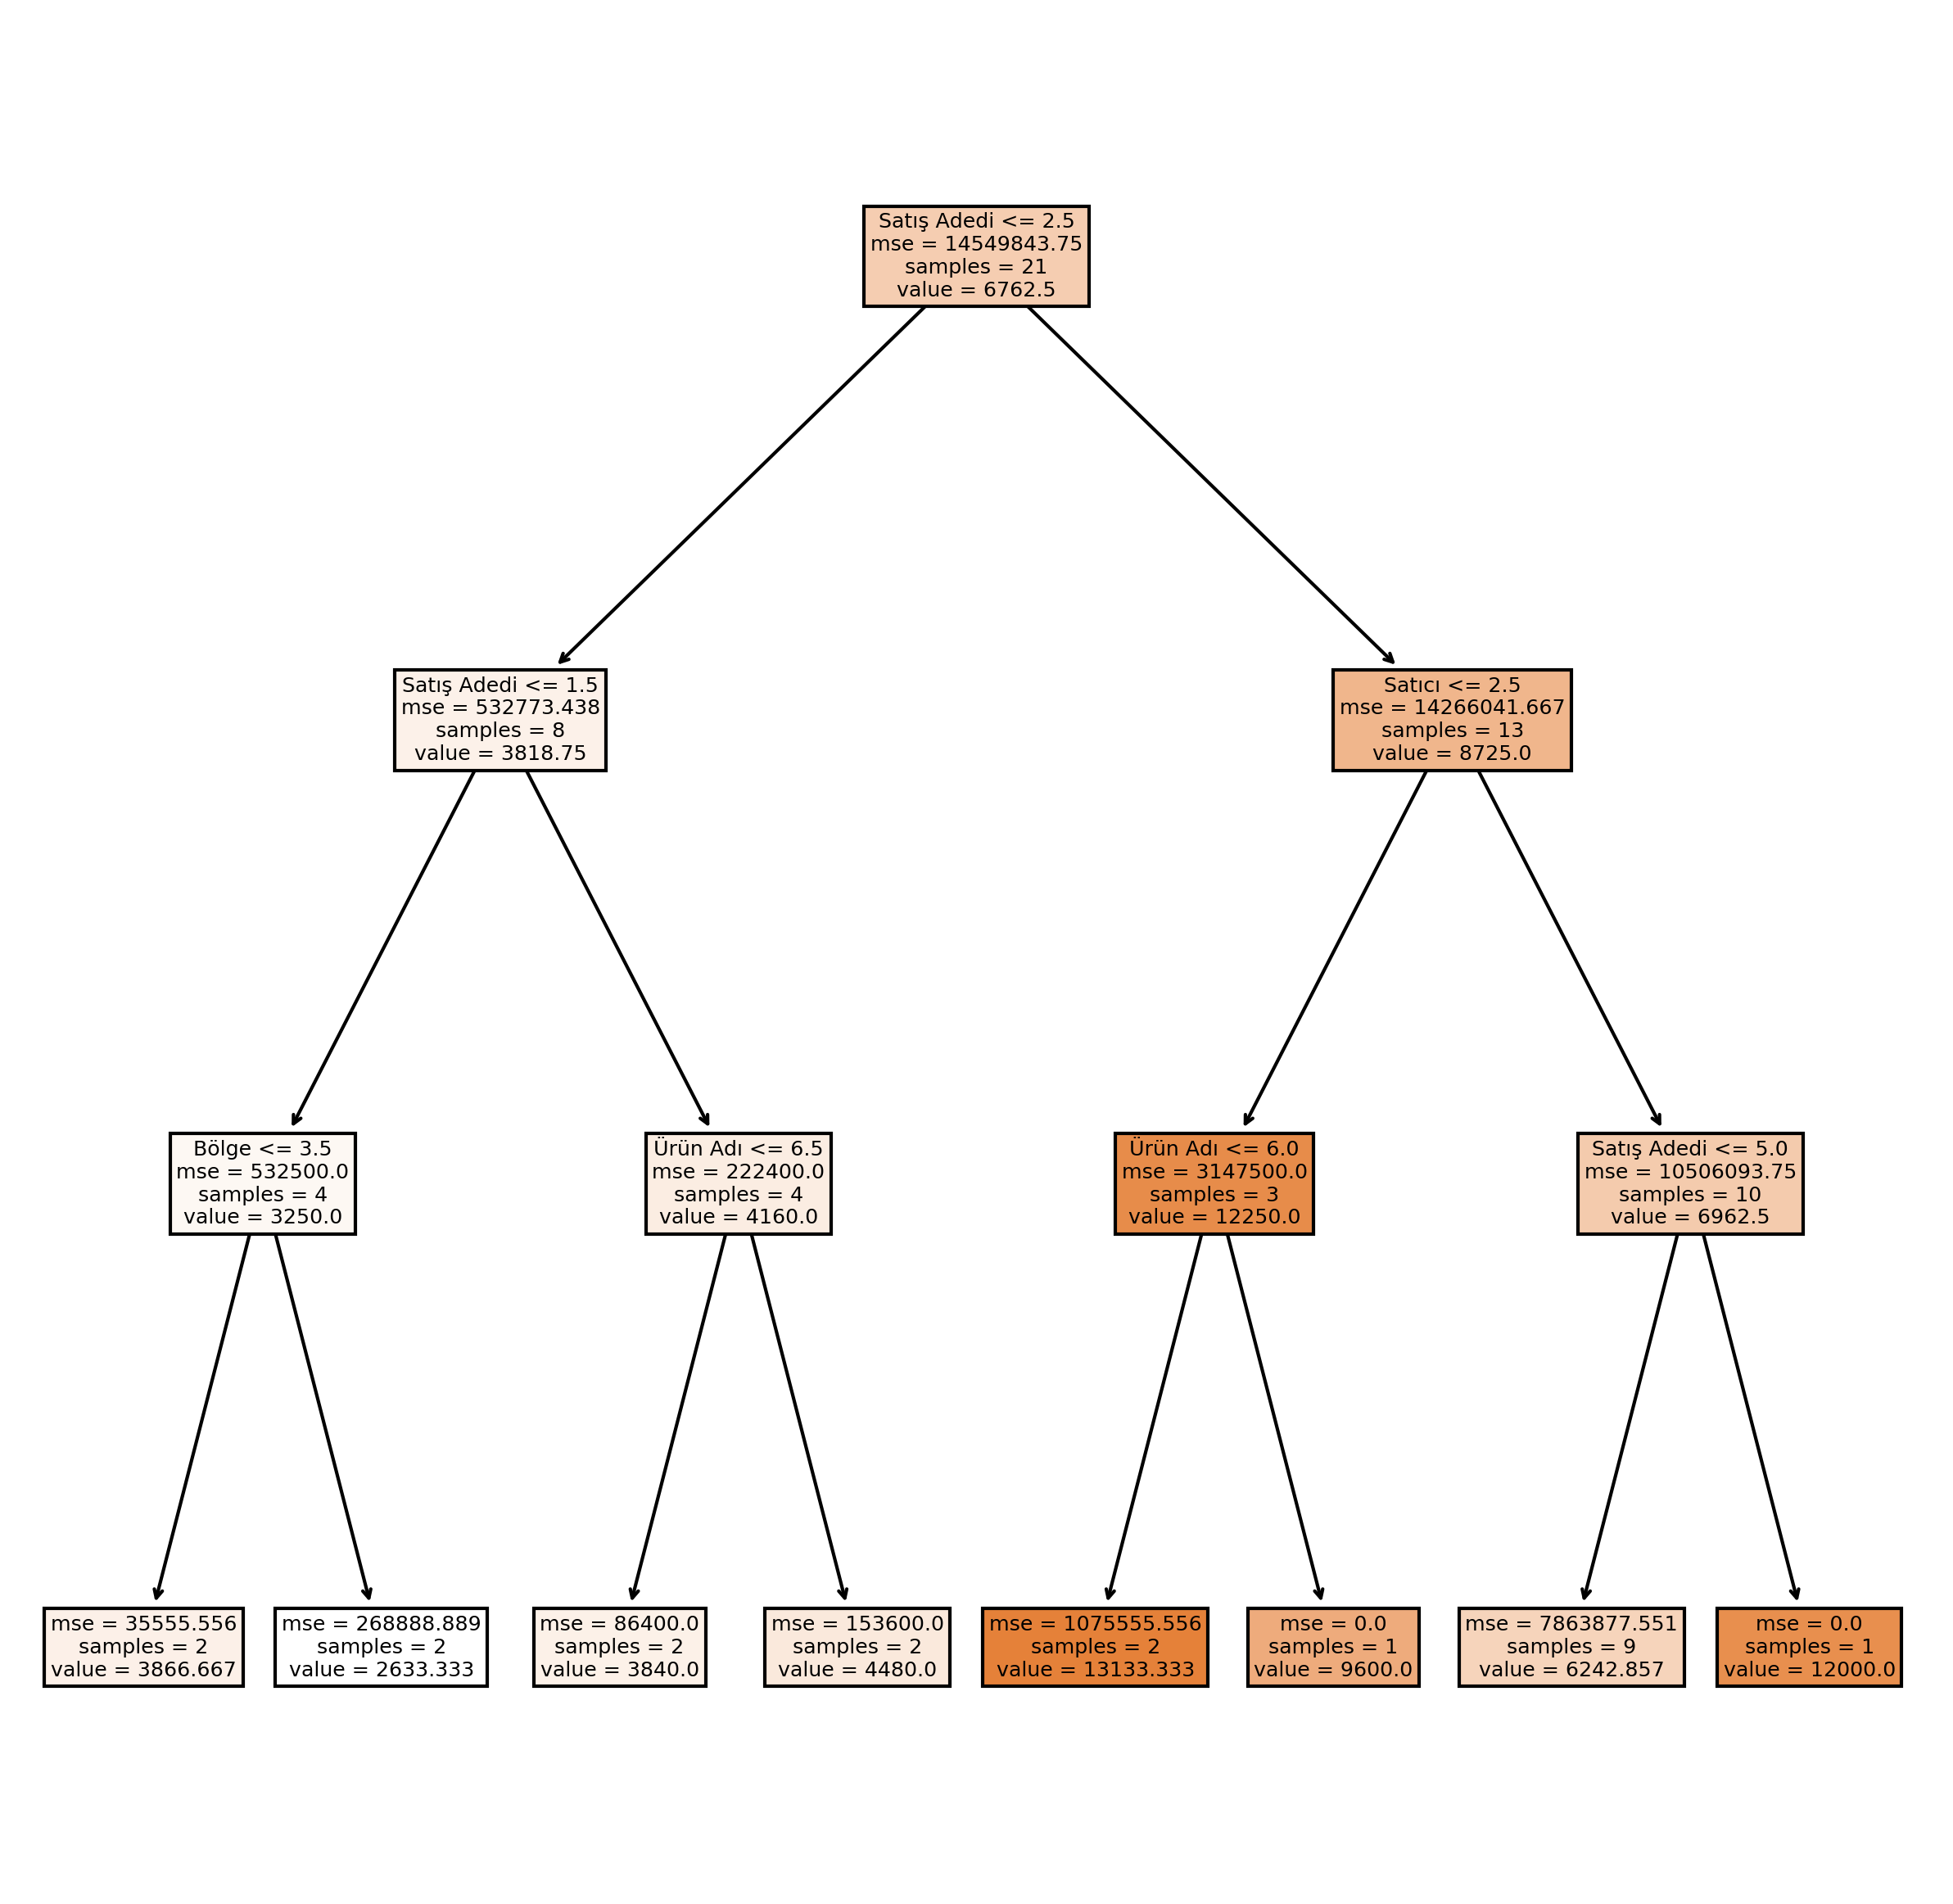

In [37]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(estimator, feature_names=df.columns,filled=True);